# 속성 추출
1. 차트 진입후 5위 이내까지 진입한 일수
2. 해당 곡 아티스트의 다른 곡이 차트에 진입한 일수
3. 차트 진입 후 5위 이내까지 일간 랭킹 상승 평균치
4. and more...

In [35]:
from getAttribute import dbQuery, chartInDays, rankIncreaseMean, rankInDays

# 신경망 코드

In [50]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

## Train dataset 추출
- 그날처럼(장덕철)
- WayBackHome(숀), 지나오다(닐로)
- WayBackHome(숀), 지나오다(닐로) 
<br/>를 조작된 데이터로 설정

In [17]:
geniedf = dbQuery("SELECT * FROM zuzak.genie where YYMMDD = 180105 and ranking <= 100")
bugsdf = dbQuery("SELECT * FROM zuzak.bugs where YYMMDD = 180710 and ranking <= 100")
mnetdf = dbQuery("SELECT * FROM zuzak.mnet where YYMMDD = 180701 and ranking <= 100")

# 데이터프레임 합치기
df = geniedf.append(bugsdf)
df = df.append(mnetdf)
df.reset_index(inplace=True, drop=True)

### 레이블 설정

In [18]:
# 조작음원 = 1
# 여기선 지나오다, way back home 조작으로 가정
tmp = df[(df['title']=='WayBackHome') | (df['title']=='지나오다') | (df['title']=='그날처럼')]
labels = np.zeros([300, 1])
labels[tmp.index] = 1

### 속성 추출 및 정규화
- 속성은 genie 차트에서 추출함

In [19]:
# 이전에 차트에 든 일수
chartindays = np.fromiter(map(chartInDays, df['title'], df['artist'], ['genie']*len(df)), np.int32)

In [20]:
# 랭킹 상승 평균값
rankimean = np.fromiter(map(rankIncreaseMean, df['title'], ['genie']*len(df)), np.int32)
rankimean = np.array((rankimean+1) / (chartindays+1))

In [21]:
# top5 진입 일수
rankindays = np.fromiter(map(rankInDays, df['title'], ['genie']*len(df)), np.int32)
rankindays = np.array((rankindays + 1) / (chartindays+1))

In [22]:
# 데이터 정규화
chartindays = np.array((chartindays+0.01) / (chartindays+1))
chartindays

array([0.01      , 0.9988475 , 0.505     , 0.01      , 0.99938547,
       0.99876712, 0.01      , 0.01      , 0.99907649, 0.505     ,
       0.98862069, 0.505     , 0.99936498, 0.97893617, 0.99932099,
       0.94789474, 0.99907042, 0.99953717, 0.9960241 , 0.99890969,
       0.9986326 , 0.96806452, 0.98403226, 0.99913613, 0.01      ,
       0.9604    , 0.01      , 0.01      , 0.99786177, 0.01      ,
       0.01      , 0.96806452, 0.99953717, 0.99891803, 0.01      ,
       0.9934    , 0.95875   , 0.01      , 0.99953717, 0.99592593,
       0.802     , 0.99868874, 0.67      , 0.01      , 0.99873239,
       0.99873563, 0.99714697, 0.99932099, 0.99901   , 0.98403226,
       0.802     , 0.9175    , 0.01      , 0.99816327, 0.01      ,
       0.99931818, 0.92928571, 0.9944382 , 0.01      , 0.99807393,
       0.99188525, 0.98821429, 0.99856313, 0.938125  , 0.99891803,
       0.99938241, 0.01      , 0.01      , 0.505     , 0.99926991,
       0.99878973, 0.01      , 0.9986326 , 0.97171429, 0.99792

### 속성 합치기

In [23]:
train_data = np.array([chartindays, rankimean, rankindays]).T
train_data

array([[1.00000000e-02, 1.00000000e+00, 3.50000000e+01],
       [9.98847497e-01, 1.11757858e-01, 2.32828871e-03],
       [5.05000000e-01, 1.50000000e+00, 2.25000000e+01],
       [1.00000000e-02, 3.00000000e+00, 3.30000000e+01],
       [9.99385475e-01, 6.20732464e-02, 1.24146493e-03],
       [9.98767123e-01, 1.74346202e-02, 3.73599004e-03],
       [1.00000000e-02, 1.00000000e+00, 5.40000000e+01],
       [1.00000000e-02, 2.00000000e+00, 6.80000000e+01],
       [9.99076493e-01, 9.04850746e-02, 1.86567164e-03],
       [5.05000000e-01, 1.00000000e+00, 2.25000000e+01],
       [9.88620690e-01, 1.14942529e+00, 2.29885057e-02],
       [5.05000000e-01, 5.00000000e+01, 1.00000000e+00],
       [9.99364978e-01, 6.41436818e-02, 1.28287364e-03],
       [9.78936170e-01, 2.08510638e+00, 4.25531915e-02],
       [9.99320988e-01, 6.79012346e-02, 1.37174211e-03],
       [9.47894737e-01, 5.15789474e+00, 1.05263158e-01],
       [9.99070423e-01, 9.38967136e-02, 1.87793427e-03],
       [9.99537167e-01, 4.67508

# 신경망 학습 

In [24]:
tf.reset_default_graph()
# [chartindays, rankimean, rankindays]
x_data = train_data
y_data = labels

#########
# 신경망 모델 구성
######
X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

# W = tf.Variable(tf.random_uniform([3, 1], -1., 1.))
W1 = tf.Variable(tf.random_normal([3, 50]))
b1 = tf.Variable(tf.random_normal([50]))
L1 = tf.nn.sigmoid(tf.add(tf.matmul(X, W1), b1))

W2 = tf.Variable(tf.random_normal([50, 1]))
b2 = tf.Variable(tf.random_normal([1]))
L2 = tf.nn.sigmoid(tf.add(tf.matmul(L1, W2), b2))

model = L2

cost = tf.reduce_mean(tf.square(model-Y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.02)
train_op = optimizer.minimize(cost)

# 신경망 모델 학습
                      
sess = tf.Session()
saver = tf.train.Saver(tf.global_variables())
                      
ckpt = tf.train.get_checkpoint_state('./model')
if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    saver.restore(sess, ckpt.model_checkpoint_path)
else:
    sess.run(tf.global_variables_initializer())
    for step in range(1000):
        sess.run(train_op, feed_dict={X: x_data, Y: y_data})
        print(step + 1, sess.run(cost, feed_dict={X: x_data, Y: y_data}))    

prediction = model
target = Y
print(sess.run(cost, feed_dict={X: x_data, Y: y_data}))    
print('예측값:', sess.run(prediction, feed_dict={X: x_data}))
print('실제값:', sess.run(target, feed_dict={Y: y_data}))

INFO:tensorflow:Restoring parameters from ./model\dnn.ckpt
예측값: [[9.5636570e-01]
 [3.4701756e-08]
 [2.8884821e-03]
 [2.7722120e-02]
 [3.3975891e-08]
 [3.3721840e-08]
 [3.1576533e-02]
 [9.2012547e-03]
 [3.4368718e-08]
 [7.5380998e-03]
 [1.4632099e-07]
 [2.0843167e-04]
 [3.4002081e-08]
 [2.6838215e-06]
 [3.4051730e-08]
 [8.7099565e-05]
 [3.4413652e-08]
 [3.3792347e-08]
 [4.2489837e-08]
 [3.4665831e-08]
 [3.5123470e-08]
 [1.6530950e-05]
 [7.3879039e-07]
 [3.3511597e-08]
 [7.0825958e-01]
 [4.7151868e-08]
 [2.3128474e-03]
 [8.8464851e-03]
 [3.6775745e-08]
 [1.8494744e-04]
 [4.9102684e-03]
 [1.5879577e-05]
 [3.3787963e-08]
 [3.3945120e-08]
 [1.8550873e-04]
 [3.5157651e-08]
 [4.1101204e-05]
 [2.3128474e-03]
 [3.3783579e-08]
 [3.4134249e-08]
 [9.5977492e-05]
 [3.5043836e-08]
 [6.2222420e-03]
 [2.3128474e-03]
 [3.4966252e-08]
 [3.3588581e-08]
 [3.8602820e-08]
 [3.3476137e-08]
 [3.4506193e-08]
 [6.9954478e-07]
 [9.5977492e-05]
 [5.4463513e-08]
 [1.8494744e-04]
 [3.5979724e-08]
 [2.3128474e-03]
 

In [ ]:
##### tensorboard cost
# x_data = train_data
# tf.summary.scalar('cost', cost)
# sess.run(tf.global_variables_initializer())

# merged = tf.summary.merge_all()
# writer = tf.summary.FileWriter('./logs', sess.graph)

# for step in range(1000):
#     sess.run(train_op, feed_dict={X: x_data, Y: y_data})
    
#     summary = sess.run(merged, feed_dict={X:x_data, Y:y_data})
#     writer.add_summary(summary)

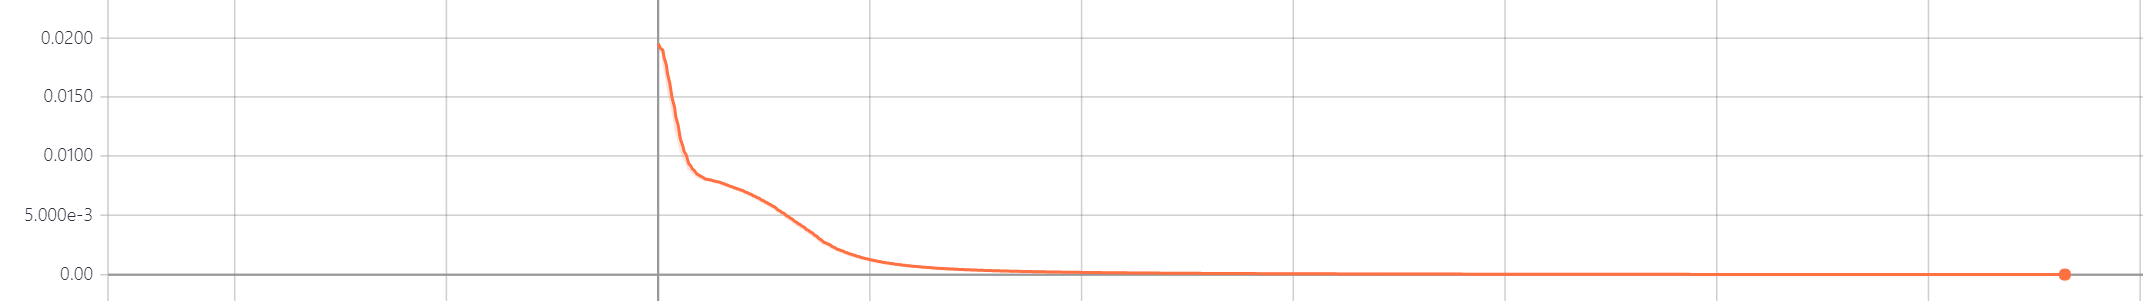

# 테스트 데이터
- mnet 차트에서의 WayBackHome, 지나오다에 대해 테스트
- 훈련 데이터는 genie차트에 대해 훈련함

In [44]:
df = dbQuery("SELECT * FROM zuzak.genie where ranking <=100 and YYMMDD = 181010")
df

,YYMMDD,ranking,title,artist
0,181010,1,삐삐,아이유(IU)
1,181010,2,시간이들겠지(Feat.Colde),로꼬
2,181010,3,하루도그대를사랑하지않은적이없었다,임창정
3,181010,4,GoodDay(Feat.팔로알토)(Prod.by코드쿤스트),pH-1&KidMilli&루피(Loopy)
4,181010,5,가을타나봐,바이브
5,181010,6,잘지내요,정승환
6,181010,7,이별길(GOODBYEROAD),iKON
7,181010,8,사이렌(Siren),선미
8,181010,9,사임사임(Feat.CHANGMO),Coogie&SUPERBEE&D.Ark
9,181010,10,우리그만하자,로이킴


### 데이터 정규화

In [45]:
# 이전에 차트에 든 일수
chartindays = np.fromiter(map(chartInDays, df['title'], df['artist'], ['mnet']*len(df)), np.int32)
# 랭킹 상승 평균값
rankimean = np.fromiter(map(rankIncreaseMean, df['title'], ['mnet']*len(df)), np.int32)
rankimean = np.array((rankimean+0.01) / (chartindays+1))
# top5 진입 일수
rankindays = np.fromiter(map(rankInDays, df['title'], ['mnet']*len(df)), np.int32)
rankindays = np.array((rankindays + 0.01) / (chartindays+1))
# 정규화
chartindays = np.array((chartindays+0.01) / (chartindays+1))
# 데이터 합치기
test_data = np.array([chartindays, rankimean, rankindays]).T

### 테스트

In [46]:
test_data

array([[9.99513274e-01, 4.86774828e-02, 4.96558505e-04],
       [9.94870466e-01, 5.07823834e-01, 5.23316062e-03],
       [9.99168067e-01, 8.32016807e-02, 8.48739496e-04],
       [1.00000000e-02, 1.00000000e-02, 1.00000000e-02],
       [9.93612903e-01, 2.58709677e-02, 9.03870968e-02],
       [9.99115282e-01, 8.93655049e-06, 8.93655049e-06],
       [9.98304795e-01, 1.66113014e-01, 1.72945205e-03],
       [9.97461538e-01, 2.53871795e-01, 2.58974359e-03],
       [1.00000000e-02, 9.80100000e+01, 1.01000000e+00],
       [9.97549505e-01, 2.45074257e-01, 2.50000000e-03],
       [1.00000000e-02, 1.00100000e+01, 1.00100000e+01],
       [9.97062315e-01, 2.99703264e-03, 1.12789318e-01],
       [9.01000000e-01, 6.01000000e-01, 9.01000000e-01],
       [9.98152985e-01, 1.82854478e-01, 1.88432836e-03],
       [1.00000000e-02, 1.00000000e-02, 1.00000000e-02],
       [9.99187192e-01, 8.12889984e-02, 8.29228243e-04],
       [1.00000000e-02, 1.00000000e-02, 1.00000000e-02],
       [9.99480588e-01, 5.19464

In [47]:
x_data = test_data

result = sess.run(prediction, feed_dict={X: x_data})
result = result.astype(np.float32)

print('예측값:', result)

예측값: [[3.3808785e-08]
 [4.7061040e-08]
 [3.4248245e-08]
 [2.2444974e-04]
 [3.6161698e-08]
 [3.3498370e-08]
 [3.5668148e-08]
 [3.7693553e-08]
 [1.6420738e-04]
 [3.7464908e-08]
 [9.8925650e-01]
 [3.5797637e-08]
 [3.6728471e-07]
 [3.6010206e-08]
 [2.2444974e-04]
 [3.4221603e-08]
 [2.2444974e-04]
 [3.3846529e-08]
 [2.2444974e-04]
 [9.1404313e-01]
 [3.3764771e-08]
 [3.5051862e-08]
 [3.3665994e-08]
 [3.3595626e-08]
 [3.4141998e-08]
 [4.0522433e-08]
 [5.8470956e-08]
 [3.4303028e-08]
 [3.4099500e-08]
 [3.6017553e-08]
 [3.3799438e-08]
 [5.2535334e-08]
 [2.2444974e-04]
 [5.0153690e-03]
 [3.4202028e-08]
 [3.4165058e-08]
 [2.2444974e-04]
 [3.4354887e-08]
 [4.3522842e-08]
 [5.4925341e-08]
 [1.6961764e-01]
 [3.3606650e-08]
 [2.2444974e-04]
 [3.4213315e-08]
 [2.2444974e-04]
 [3.4066215e-08]
 [3.4421593e-08]
 [3.3218434e-01]
 [5.7553602e-03]
 [6.9010758e-01]
 [4.9554110e-01]
 [3.7053084e-08]
 [2.2444974e-04]
 [2.2444974e-04]
 [2.2444974e-04]
 [3.6681385e-08]
 [3.5788972e-08]
 [9.3395876e-08]
 [1.47641

In [48]:
df['prediction'] = result
df

,YYMMDD,ranking,title,artist,prediction
0,181010,1,삐삐,아이유(IU),3.380879e-08
1,181010,2,시간이들겠지(Feat.Colde),로꼬,4.706104e-08
2,181010,3,하루도그대를사랑하지않은적이없었다,임창정,3.424825e-08
3,181010,4,GoodDay(Feat.팔로알토)(Prod.by코드쿤스트),pH-1&KidMilli&루피(Loopy),2.244497e-04
4,181010,5,가을타나봐,바이브,3.616170e-08
5,181010,6,잘지내요,정승환,3.349837e-08
6,181010,7,이별길(GOODBYEROAD),iKON,3.566815e-08
7,181010,8,사이렌(Siren),선미,3.769355e-08
8,181010,9,사임사임(Feat.CHANGMO),Coogie&SUPERBEE&D.Ark,1.642074e-04
9,181010,10,우리그만하자,로이킴,3.746491e-08


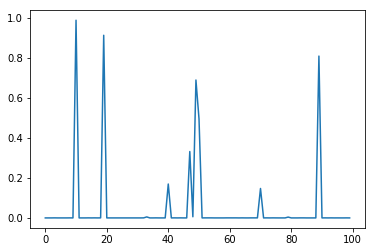

In [51]:
plt.plot(df['prediction'])

## 모델 저장

In [ ]:
# saver = tf.train.Saver(tf.global_variables())
# saver.save(sess, './model/dnn.ckpt')